In [ ]:
import math, random
import gym
import numpy as np
import sys
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import time

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch
from common.entropy import *


env_id = "PongNoFrameskip-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x /= 255.0
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
    def predict(self, state):
        state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        return q_value
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 and classname.find('Layer') == -1:
            nn.init.xavier_normal(m.weight)
        elif classname.find('Linear') != -1:
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0.1)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

<IPython.core.display.Javascript object>


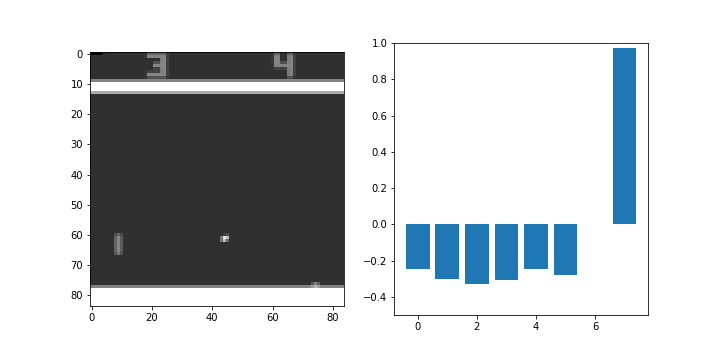

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 Q_Entropy:  99.97

KeyboardInterrupt: 

In [46]:
model = torch.load('../epsilon/model/epsilon_PongNoFrameskip-v0.model')
state = env.reset()
done = False
%matplotlib notebook
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plt.ion()
fig.show()
fig.canvas.draw()

for i in range(10):
    state = env.reset()
    done = False
    while not done:
        #env.render()
        action = model.act(state,0)
        q_values = model.predict(state).data.cpu().numpy()[0]
        q_entropy = entropy(q_values)
        QE = q_entropy/(np.log(6))*100
        QE_show = np.reshape(QE-99, [-1,])
        #action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        
        print('\r Q_Entropy: ', np.round(QE, 2), end='')
        
        ax.clear()
        ax2.clear()
        ax.imshow(state[0,:,:].T, cmap='gray')
        ax2.set_ylim(-0.5, 1)
        ax2.bar(range(8), np.concatenate([q_values,np.zeros([1,]),QE_show], axis=0))
        fig.canvas.draw()
        
        time.sleep(0.5)
    env.close()

In [15]:
env.close()

In [35]:
QE = np.reshape(QE, [-1,])

In [36]:

np.concatenate([q_values, QE], axis=0)

array([0.0345502 , 0.22209151, 0.30142534, 0.20506074, 0.31284237,
       0.34379831, 0.99724249])